<div style="background-color:yellow; text-align:center; text-align:center; padding:40px;">
<h1  style="color:red;" > DI-725 : Transformers and Attention-Based Deep Networks </h1>   
<h2  style="color:red;" > Assignment - 2 </h2>
<br>
<br>
<h4  style="color:red;" >Turgay Yıldız</h4>
<br>
<h4  style="color:red;" >Graduate School of Informatics,  Middle East Technical University (METU)</h4>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import the Relevant Packages  </h2>
</div>

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch import Tensor
import torchvision

from einops.layers.torch import Rearrange 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

from torch.optim import AdamW

import json

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tqdm
from PIL import Image

import wandb
import os
import cv2

from torch.amp import GradScaler, autocast


import requests
%config InlineBackend.figure_format = 'retina'
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [2]:
print(torch.cuda.is_available())

True


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  WANDB </h2>
</div>

In [3]:
print(os.getcwd())

/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2


In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Assignment_2__2697258.ipynb" 

In [5]:
#wandb.finish() 

In [6]:
run  =  wandb.init(project="DI_725_Assignment_2___2697258", entity="DI_725_Assignment_2___2697258") 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725___Final_Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Import Dataset  </h2>
</div>

In [7]:
path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/"

In [8]:
images_p        =    os.listdir(path + "auair2019/images")
annotations_p   =   path + "auair2019/annotations.json"

In [9]:
images_p[:3]

['frame_20190905103112_xx_0000365.jpg',
 'frame_20190906150731_xx_0002188.jpg',
 'frame_20190906150731_x_0001674.jpg']

In [10]:
with open(annotations_p, 'r') as f:
    annotations = json.load(f)

In [11]:
annotations_info    =   annotations["info"]
annotations_ann     =   annotations["annotations"]

In [12]:
annotations_info

{'description': 'AUAIR 2019 Dataset',
 'url': 'https://bozcani.github.io/AU-AIR-dataset.html',
 'version': '1.0',
 'year': '2019',
 'contributor': 'Ilker Bozcan',
 'date_created': '2019/10/01'}

In [13]:
len(annotations_ann)

32823

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  BBoxes </h2>
</div>

In [14]:
annotations_ann[1]["bbox"]

[{'top': 857, 'left': 976, 'height': 86, 'width': 139, 'class': 0},
 {'top': 11, 'left': 624, 'height': 210, 'width': 328, 'class': 1}]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Average Length of Classes for an image </h2>
</div>

In [15]:
summ = 0

for i in range(len(annotations_ann)):

    summ   +=    len(annotations_ann[i]["bbox"])

In [16]:
summ

132031

In [17]:
summ /  len(annotations_ann) 

4.0225147000578865

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Max Class Indices in an image</h2>
</div>

In [18]:
summs   =  [] 

for i in range(len(annotations_ann)):

    summs.append(len(annotations_ann[i]["bbox"]))

In [19]:
np.array(summs).max()

56

In [20]:
np.array(summs).argmax()

25251

In [21]:
annotations_ann[25251]["bbox"][:3]

[{'top': 396, 'left': 439, 'height': 35, 'width': 101, 'class': 1},
 {'top': 375, 'left': 453, 'height': 30, 'width': 105, 'class': 1},
 {'top': 347, 'left': 464, 'height': 31, 'width': 83, 'class': 1}]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Unique Classes</h2>
</div>

In [22]:
lst   =   []

for i in range(len(annotations_ann)):

    bbox   =   annotations_ann[i]["bbox"]

    for j in range(len(bbox)):

        label   =   bbox[j]["class"] 

        if label  not  in  lst :
    
            lst.append(label) 


In [23]:
lst

[1, 0, 2, 3, 5, 7, 4, 6]

In [24]:
len(lst)

8

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Preprocess Data</h2>
</div>

In [13]:
def preprocess_annotations(annotations_ann, max_length=0):

    all_bboxes = []
    all_images = [] 

    path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/auair2019/images/"

    for i in tqdm.tqdm(range(len(annotations_ann))):

        
        image_name    =     annotations_ann[i]["image_name"] 
        img_path      =     os.path.join(path ,  image_name)   


        all_images.append(img_path)


        
        len_bbox   =  len(annotations_ann[i]["bbox"]) 
        bbox_list  =  [    ]  

        for j in range(len_bbox):

            top     = annotations_ann[i]["bbox"][j]["top"]    / 1080.0
            left    = annotations_ann[i]["bbox"][j]["left"]   / 1920.0
            height  = annotations_ann[i]["bbox"][j]["height"] / 1080.0
            width   = annotations_ann[i]["bbox"][j]["width"]  / 1920.0
            clas    =   annotations_ann[i]["bbox"][j]["class"]
            

            one_hot          =   [0,0,0,  0,0,0,  0,0  ]
            one_hot[clas]    =   1  

            bbox_list.append([top, left, height, width] + one_hot) 


        bbox_arr   =   np.array(bbox_list, dtype=np.float32)


        if  len_bbox  <  max_length:

            pad          =   np.zeros((max_length - len_bbox, 12), dtype=np.int32)    #   4   +   8  

            bbox_arr     =   np.concatenate([bbox_arr, pad], axis=0)

        elif len_bbox  >  max_length:

            bbox_arr  =   bbox_arr[:max_length]

        all_bboxes.append(bbox_arr) 
    

    all_bboxes = np.stack(all_bboxes, axis=0) 
    all_images = np.stack(all_images, axis=0)

    return    all_images,    all_bboxes 


In [15]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann, max_length=60) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32823/32823 [00:00<00:00, 84848.12it/s]


In [27]:
all_images.shape,  all_bboxes.shape

((32823,), (32823, 60, 12))

In [28]:
all_bboxes[2, 0, :] 

array([0.00185185, 0.29895833, 0.0712963 , 0.1875    , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [29]:
all_bboxes[..., :4].max()

1.0

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check the Preprocessed Data</h2>
</div>

In [16]:
all_images.shape

(32823,)

In [17]:
all_bboxes.shape

(32823, 60, 12)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Original Dimensions </h2>
</div>

In [18]:
num   =  0

In [19]:
img   =   Image.open(all_images[num]).convert("RGB")

In [20]:
all_bboxes.shape

(32823, 60, 12)

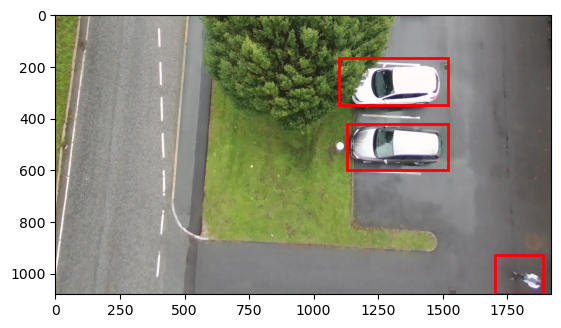

In [21]:
fig, ax = plt.subplots(1)


ax.imshow(img)

for i in range(60):
    
    rect = patches.Rectangle((all_bboxes[num][i][1]*1920, all_bboxes[num][i][0]*1080), all_bboxes[num][i][3]*1920, all_bboxes[num][i][2]*1080, linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Split Dataset according to the Report Paper </h2>
</div>

```python
annotations_train_val        =    all_bboxes[:30000,    :,  :]
annotations_test             =    all_bboxes[30000:-1,  :,  :] 
```

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Prepare Dataset for Training </h2>
</div>

In [129]:
class AUAIRDataset(Dataset):

    def __init__(self,  test = False,  transform=None):

        
        self.transform          =   transform 
       

        all_images,     all_bboxes    =    preprocess_annotations(annotations_ann, max_length=100) 

        all_bboxes[:,  :,  0]   =  (all_bboxes[:,  :,  0] ) 
        all_bboxes[:,  :,  2]   =  (all_bboxes[:,  :,  2] ) 
        
        all_bboxes[:,  :,  1]   =  (all_bboxes[:,  :,  1] ) 
        all_bboxes[:,  :,  3]   =  (all_bboxes[:,  :,  3] )  
        
        if test:

            self.annotations    =   all_bboxes[30000:-1,  :,  :]  
            self.img_paths      =   all_images[30000:-1] 

        else:

            self.annotations    =   all_bboxes[:30000,    :,  :]
            self.img_paths      =   all_images[:30000]  

    
    def __len__(self):
        
        return    100 #len(self.annotations)  


    def __getitem__(self, idx):

        data          =     self.annotations[idx]   
        img_path      =     self.img_paths[idx]  
            
        img           =     Image.open(img_path).convert("RGB")   


     
        if self.transform:
            
            x = self.transform(img) 

        else :

            x = img 

        
        x             =     np.array(x, dtype=np.float32) / 255.0  
        x             =     x = torch.tensor(x).view(3, 800, 800)   
        
        return     x,       torch.tensor(data[..., :4]).float()    ,   torch.tensor(data[..., 4:]).float() 



In [130]:
data_transform = transforms.Compose([
    
    transforms.Resize((800,800)), 
])


In [211]:
# standard PyTorch mean-std input image normalization
#transform = T.Compose([
#    T.Resize(800),
#    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#])

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Training   </h2>
</div>

In [212]:
dataset      =   AUAIRDataset(    test=False,    transform  =  data_transform)  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32823/32823 [00:00<00:00, 78675.60it/s]


In [213]:
len(dataset)

30000

In [214]:
train_size   =    int(0.9 * len(dataset))
val_size     =    len(dataset) - train_size 

In [215]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) 

In [216]:
train_loader   =   DataLoader(train_dataset, batch_size=8, num_workers  =   8,   pin_memory = True,    shuffle=True)
val_loader     =   DataLoader(val_dataset,   batch_size=8, num_workers  =   8,   pin_memory = True,    shuffle=True) 

In [217]:
for a, b, c in train_loader:
    break 

In [218]:
a.shape

torch.Size([8, 3, 800, 800])

In [219]:
b.shape

torch.Size([8, 100, 4])

In [220]:
c.shape

torch.Size([8, 100, 8])

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Testing (Unseen Data)   </h2>
</div>

In [51]:
#dataset2       =   AUAIRDataset(all_images,  all_bboxes,      test=True,    transform  =  data_transform)

In [52]:
#len(dataset2)

In [53]:
#test_loader   =   DataLoader(dataset2,  batch_size=16, num_workers  =   8,   pin_memory = True,   shuffle=True)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Dimensions of Scaled-Data  </h2>
</div>

In [44]:
for imgs, bbox, clas in train_loader:
    break

In [45]:
imgs.shape

torch.Size([2, 3, 360, 640])

In [46]:
bbox.shape

torch.Size([2, 60, 4])

In [47]:
bbox[0][:5]

tensor([[0.8528, 0.5875, 0.1398, 0.0693],
        [0.0000, 0.2906, 0.1787, 0.2245],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])

In [48]:
height   =  360
width    =  640 

In [49]:
bbox[:,  :,  0]   =  (bbox[:,  :,  0] * height).int()
bbox[:,  :,  2]   =  (bbox[:,  :,  2] * height).int() 

bbox[:,  :,  1]   =  (bbox[:,  :,  1] * width).int() 
bbox[:,  :,  3]   =  (bbox[:,  :,  3] * width).int()  

In [55]:
bbox[0][:5]

tensor([[307., 376.,  50.,  44.],
        [  0., 186.,  64., 143.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]])

In [56]:
num  =  0

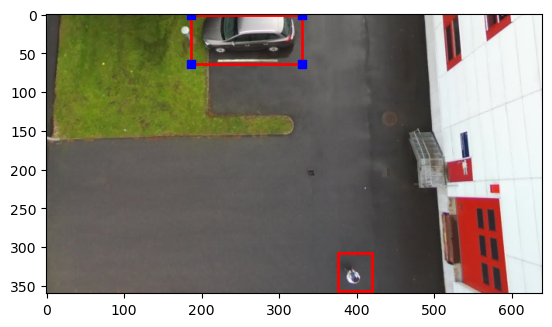

In [61]:
fig, ax = plt.subplots(1)


ax.imshow(imgs[num].reshape(height, width, 3))

plt.plot([186], [0], "bs")         #   1,       0   
plt.plot([186], [0+64], "bs")      #   1,       0+2
plt.plot([186+143], [0], "bs")     #   1+3      0
plt.plot([186+143], [0+64], "bs")  #   1+3      0+2 

for k in range(60):
    
    rect = patches.Rectangle((bbox[num][k][1] , bbox[num][k][0]), bbox[num][k][3], bbox[num][k][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:10px;">
<h2>  Model </h2>
</div>


In [168]:
class DETR(nn.Module):

    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc


        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    
        batch_size = inputs.size(0)
    
        # repeat query positions for each batch
        query_pos = self.query_pos.unsqueeze(0).repeat(batch_size, 1, 1)  # [batch_size, num_queries, D]
        query_pos = query_pos.permute(1, 0, 2)  # [num_queries, batch_size, D]
    
        # flatten spatial dimensions and permute to match transformer input shape
        src = pos + 0.1 * h.flatten(2).permute(2, 0, 1)  # [HW, batch_size, D]
    
        # propagate through the transformer
        h = self.transformer(src, query_pos).transpose(0, 1)  # [batch_size, num_queries, D]
    
        # finally project transformer outputs to class labels and bounding boxes
        return {
            'pred_logits': self.linear_class(h),
            'pred_boxes': self.linear_bbox(h).sigmoid()
        }




<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Clear CUDA :</h2>
</div>

In [21]:
import gc

In [22]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            del obj
            
    except:
        pass
            

/home/turgay/anaconda3/envs/DI_725_assignment_2/lib/python3.8/site-packages/torch/__init__.py:836: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [23]:

def clear_cuda(verbose=False):

    import gc
    # List of big variables to explicitly delete (add as needed)
    big_vars = ['model', 'train_loader', 'val_loader', 'optimizer', 'scheduler']

    for var in big_vars:
        if var in globals():
            del globals()[var]

    gc.collect()
    torch.cuda.empty_cache()

    if verbose:
        print(torch.cuda.memory_summary())



<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Loaders :</h2>
</div>

In [25]:
def loaders(batch_size=0, num_workers =0, shuffle=True, transform=None,  test=False, pin_memory=False):

    dataset      =   AUAIRDataset(    test=test,    transform  =  transform)
    train_size   =    int(0.9 * len(dataset))
    val_size     =    len(dataset) - train_size 

    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) 

    train_loader   =   DataLoader(train_dataset, batch_size=batch_size, num_workers  =   num_workers,   pin_memory = pin_memory,    shuffle=shuffle)
    val_loader     =   DataLoader(val_dataset,   batch_size=batch_size, num_workers  =   num_workers,   pin_memory = pin_memory,    shuffle=shuffle) 

    return     train_loader,     val_loader       



<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check Number of  Parameters :</h2>
</div>

In [169]:
clear_cuda()

In [170]:
train_loader,   val_loader   =   loaders(batch_size = 4, num_workers = 4, shuffle=True, transform=data_transform) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32823/32823 [00:00<00:00, 83869.68it/s]


In [171]:
#train_loader   =   DataLoader(train_dataset, batch_size=8, num_workers  =   8,   pin_memory = True,    shuffle=True)
#val_loader     =   DataLoader(val_dataset,   batch_size=8, num_workers  =   8,   pin_memory = True,    shuffle=True)   

In [172]:
model          =  DETR(8)

In [173]:
for param in model.backbone.parameters():
    param.requires_grad = False 

In [174]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters in the model:", num_params)

Number of trainable parameters in the model: 17930253


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Employ GPU</h2>
</div>

In [175]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [176]:
device

device(type='cuda')

In [177]:
model      =        model.to(device)   

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  To Save Weights and Losses : </h2>
</div>

In [178]:
path_model   =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_weight_1.pth"
path_losses  =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_losses_1.pth"  

In [180]:
state_dict = torch.hub.load_state_dict_from_url(
                                                    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
                                                    map_location='cuda', check_hash=True)

In [182]:
state_dict.keys()

dict_keys(['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.0.self_attn.out_proj.weight', 'transformer.encoder.layers.0.self_attn.out_proj.bias', 'transformer.encoder.layers.0.linear1.weight', 'transformer.encoder.layers.0.linear1.bias', 'transformer.encoder.layers.0.linear2.weight', 'transformer.encoder.layers.0.linear2.bias', 'transformer.encoder.layers.0.norm1.weight', 'transformer.encoder.layers.0.norm1.bias', 'transformer.encoder.layers.0.norm2.weight', 'transformer.encoder.layers.0.norm2.bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.out_proj.weight', 'transformer.encoder.layers.1.self_attn.out_proj.bias', 'transformer.encoder.layers.1.linear1.weight', 'transformer.encoder.layers.1.linear1.bias', 'transformer.encoder.layers.1.linear2.weight', 'transformer.encoder.layers.1.linear2.

In [183]:
if 1:

    state_dict = torch.hub.load_state_dict_from_url(
                                                    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
                                                    map_location='cuda', check_hash=True)

    for k in list(state_dict.keys()):
        if k.startswith('linear_class'):
            del state_dict[k] 

    
    torch.save({
            'model_state_dict': state_dict,
            'best_loss'       : 9999999999999,
        }, path_model)   

In [165]:
if 0:
    
    torch.save({
        
            'train_loss'    : [],
            'val_loss'      : [], 
    
            'epochs'        : [],
    
        }, path_losses)    

In [184]:
if 1:
    
    checkpoint_weights   =   torch.load(path_model, weights_only=True) 
    checkpoint_losses    =   torch.load(path_losses, weights_only=True)  
    
    model.load_state_dict(checkpoint_weights['model_state_dict'])
    
    best_loss       =  checkpoint_weights['best_loss'] 
    train_loss      =  checkpoint_losses['train_loss']
    val_loss        =  checkpoint_losses['val_loss']
    
    epochs          =  checkpoint_losses['epochs'] 

RuntimeError: Error(s) in loading state_dict for DETR:
	Missing key(s) in state_dict: "linear_class.weight", "linear_class.bias". 

In [167]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters in the model:", num_params)

Number of trainable parameters in the model: 17951584


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Loss Functions : </h2>
</div>

In [361]:
import math

In [225]:
def ciou_loss(pred_boxes, target_boxes, eps=1e-7, sanity=None):
    
    x1_p, y1_p, x2_p, y2_p = pred_boxes[:, 0], pred_boxes[:, 1], pred_boxes[:, 2], pred_boxes[:, 3]
    x1_t, y1_t, x2_t, y2_t = target_boxes[:, 0], target_boxes[:, 1], target_boxes[:, 2], target_boxes[:, 3]

    w_p  = (x2_p - x1_p)
    h_p  = (y2_p - y1_p)
    w_t  = (x2_t - x1_t)
    h_t  = (y2_t - y1_t)

    cx_p = (x1_p + x2_p) / 2
    cy_p = (y1_p + y2_p) / 2
    cx_t = (x1_t + x2_t) / 2
    cy_t = (y1_t + y2_t) / 2

    inter_x1   = torch.max(x1_p, x1_t)
    inter_y1   = torch.max(y1_p, y1_t)
    inter_x2   = torch.min(x2_p, x2_t)
    inter_y2   = torch.min(y2_p, y2_t)
    inter_w    = (inter_x2 - inter_x1).clamp(min=0)
    inter_h    = (inter_y2 - inter_y1).clamp(min=0)
    inter_area = inter_w * inter_h

    area_p = w_p * h_p
    area_t = w_t * h_t
    union  = area_p + area_t - inter_area + eps
    iou    = inter_area / union

    center_distance = (cx_p - cx_t)**2 + (cy_p - cy_t)**2

    enc_x1 = torch.min(x1_p, x1_t)
    enc_y1 = torch.min(y1_p, y1_t)
    enc_x2 = torch.max(x2_p, x2_t)
    enc_y2 = torch.max(y2_p, y2_t)
    enc_w  = (enc_x2 - enc_x1)
    enc_h  = (enc_y2 - enc_y1)
    c2     = (enc_w**2 + enc_h**2) + eps

    atan_p = torch.atan(w_p / (h_p + eps))
    atan_t = torch.atan(w_t / (h_t + eps))
    v      = (4 / (math.pi ** 2)) * (atan_t - atan_p)**2

    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    ciou_val = iou - (center_distance / c2) - alpha * v
    loss     = 1 - ciou_val

    if sanity:
        print('iou:', iou.mean().item())
        print('center_distance:', center_distance.mean().item())
        print('v:', v.mean().item())
        print('alpha:', alpha.mean().item())
    return loss.mean()

def ciou_loss_batch(pred, target, eps=1e-7, sanity=None):
    B, N, _     = pred.shape
    pred_xyxy   = torch.zeros((B, N, 4), device=pred.device)
    target_xyxy = torch.zeros((B, N, 4), device=target.device)
    pred_xyxy[:, :, 0] = pred[:, :, 1]
    pred_xyxy[:, :, 1] = pred[:, :, 0]
    pred_xyxy[:, :, 2] = pred[:, :, 1] + pred[:, :, 3]
    pred_xyxy[:, :, 3] = pred[:, :, 0] + pred[:, :, 2]
    target_xyxy[:, :, 0] = target[:, :, 1]
    target_xyxy[:, :, 1] = target[:, :, 0]
    target_xyxy[:, :, 2] = target[:, :, 1] + target[:, :, 3]
    target_xyxy[:, :, 3] = target[:, :, 0] + target[:, :, 2]
    pred_xyxy   = pred_xyxy.view(-1, 4)
    target_xyxy = target_xyxy.view(-1, 4)
    return ciou_loss(pred_xyxy, target_xyxy, eps, sanity=sanity)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2> Sanity Check for loss  </h2>
</div>

In [102]:
# identical boxes test
B, N = 2, 5
test_boxes = torch.tensor([[10, 20, 30, 40, 0],
                           [50, 60, 70, 80, 0],
                           [15, 25, 35, 45, 0],
                           [100, 110, 120, 130, 0],
                           [5, 5, 5, 5, 0]], device='cuda:0').float()

bbox_org = test_boxes.unsqueeze(0).repeat(B, 1, 1)


In [65]:
loss = ciou_loss_batch(bbox_org, bbox_org, sanity=True)

iou: 1.0
center_distance: 0.0
v: 0.0
alpha: 0.0


In [66]:
print('Sanity check loss (should be near 0):', loss.item())

Sanity check loss (should be near 0): 0.0


### Now, check for the preprocessed data:

In [68]:
optimizer       =   AdamW(model.parameters(), lr=0.0001)

for img, data in tqdm.tqdm(train_loader):
    
    img       =   img.to(device)
    data      =   data.to(device)   
    
    optimizer.zero_grad()

    with autocast(device_type='cuda'):

        
        bbox_pred,   clas_pred          =   model(img)       #   out   12  (first 4: bboxes, last 8: classes) 
 

        bbox_org       =   data[..., :4]
        clas_org       =   data[...,  4:]
        break 

  0%|          | 0/38 [00:02<?, ?it/s]


In [69]:
bbox_pred.shape

torch.Size([24, 60, 4])

In [70]:
bbox_org.shape

torch.Size([24, 60, 4])

In [69]:
loss = ciou_loss_batch(bbox_org, bbox_org, sanity=True)

iou: 1.0
center_distance: 0.0
v: 0.0
alpha: 0.0


In [70]:
loss

tensor(0., device='cuda:0')

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Training : </h2>
</div>

In [275]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [112]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    
    return probas[keep], bboxes_scaled

In [113]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im  = Image.open(requests.get(url, stream=True).raw)

In [114]:
im.size

(640, 480)

In [ ]:
scores, boxes = detect(torch.tensor(np.array(im)).to(device), model, transform)

In [226]:
def train(num_epochs=0, patience=0, counter=0,  best_loss=best_loss):

    for epoch in range(num_epochs):

        model.train() 
        total_loss_train   =   0
        
        for img, bbox in tqdm.tqdm(train_loader):
            
            img       =   img.to(device)
            bbox      =   bbox.to(device)   
            clas      =   clas.to(device)
            
            optimizer.zero_grad()

            with autocast(device_type='cuda'):


                pred_box, pred_clas         =   model(img)
                

                loss_bbox         =   1 * criterion_l1(pred_box, bbox) + 1 * torchvision.ops.generalized_box_iou_loss(bbox.view(-1, 4), pred_box.view(-1, 4), reduction='mean') 
                loss_bbox         =   1 * loss_bbox
                loss_class        =   0  #criterion_bce(pred_clas, clas)

                loss              =   loss_bbox + loss_class
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            total_loss_train   +=   loss.item()

        total_loss_train   /=   len(train_loader)
        train_loss.append(total_loss_train)
        run.log({"Train Loss": total_loss_train})
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train LOSS : {total_loss_train:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train BBOX : {loss_bbox:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train CLS  : {loss_class:.4f}           |")
        print("-------------------------------------------------------------------------------")

        model.eval()
        
        total_loss_val   =   0.0

        with torch.no_grad():
            
            for img, bbox in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                
                img       =   img.to(device) 
                bbox      =   bbox.to(device)   
                #clas      =   clas.to(device)
            
                with autocast(device_type='cuda'):


                    pred_box, pred_clas         =   model(img)
                

                    loss_bbox         =   1 * criterion_l1(pred_box, bbox) + 1 * torchvision.ops.generalized_box_iou_loss(bbox.view(-1, 4), pred_box.view(-1, 4), reduction='mean') 
                    loss_bbox         =   1 * loss_bbox
                    loss_class        =   0 #criterion_bce(pred_clas, clas)
    
                    loss              =   loss_bbox + loss_class
        
                
                total_loss_val   +=   loss.item()

        total_loss_val   /=   len(val_loader)
        val_loss.append(total_loss_val)
        
        run.log({"Val Loss": total_loss_val})
        
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation LOSS : {total_loss_val:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation BBOX : {loss_bbox:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation CLS : {loss_class:.4f}           |")
        print("-------------------------------------------------------------------------------")
        
        if len(val_loss) >= 2:
            res       =   ((val_loss[-2] - val_loss[-1]) / val_loss[-2]) * 100
            print("-------------------------------------------------------------------------------")
            print(f"|              Change in loss is      %   {res:.2f}                               |")
            print("-------------------------------------------------------------------------------")
        if total_loss_val < best_loss:
            
            print("*************...saving best model *************")
            best_loss       =   total_loss_val
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_loss': best_loss,
            }, path_model)
        epochs.append(epoch)
        torch.save({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epochs': epochs,
        }, path_losses)
        if (len(val_loss) >= 2) and (val_loss[-2] > val_loss[-1]):
            counter       =   0
        else:
            counter       +=   1
            if counter >= patience:
                print("Early stopping!")
                break
        scheduler.step()
        torch.cuda.empty_cache()

In [158]:
def train(
    num_epochs: int = 0,
    patience: int = 0,
    best_loss: float = float('inf'),
    counter: int = 0,
):
    """
    Training loop with combined bbox and classification loss.
    """
    train_loss, val_loss, epochs = [], [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_train_loss = 0.0
        total_bbox_loss  = 0.0
        total_clas_loss  = 0.0

        for img, bbox, clas in tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch}/{num_epochs}"):
            img, bbox, clas = img.to(device), bbox.to(device), clas.to(device)
            optimizer.zero_grad()

            # forward pass
            outputs     = model(img)
            pred_boxes  = outputs['pred_boxes']
            pred_clas   = outputs['pred_logits']

            # compute losses
            bbox_loss = (
                criterion_l1(pred_boxes, bbox)
                + torchvision.ops.generalized_box_iou_loss(
                    bbox.view(-1, 4),
                    pred_boxes.view(-1, 4),
                    reduction='mean'
                )
            )
            clas_loss = criterion_bce(pred_clas, clas)
            loss = bbox_loss + clas_loss

            # backward + optimize
            loss.backward()
            optimizer.step()

            # accumulate
            total_train_loss += loss.item()
            total_bbox_loss  += bbox_loss.item()
            total_clas_loss  += clas_loss.item()

        # compute averages
        avg_train_loss = total_train_loss / len(train_loader)
        avg_bbox_loss  = total_bbox_loss  / len(train_loader)
        avg_clas_loss  = total_clas_loss  / len(train_loader)
        train_loss.append(avg_train_loss)

        # log
        run.log({
            "Train Loss": avg_train_loss,
            "Train BBox": avg_bbox_loss,
            "Train Cls": avg_clas_loss
        })

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"BBox Loss: {avg_bbox_loss:.4f} | "
            f"Cls Loss: {avg_clas_loss:.4f}"
        )

        # validation
        model.eval()
        total_val_loss = 0.0
        total_val_bbox = 0.0
        total_val_clas = 0.0

        with torch.no_grad():
            for img, bbox, clas in tqdm.tqdm(val_loader, desc=f"Validating Epoch {epoch}/{num_epochs}"):
                img, bbox, clas = img.to(device), bbox.to(device), clas.to(device)
                outputs     = model(img)
                pred_boxes  = outputs['pred_boxes']
                pred_clas   = outputs['pred_logits']

                bbox_loss = (
                    criterion_l1(pred_boxes, bbox)
                    + torchvision.ops.generalized_box_iou_loss(
                        bbox.view(-1, 4),
                        pred_boxes.view(-1, 4),
                        reduction='mean'
                    )
                )
                clas_loss = criterion_bce(pred_clas, clas)
                loss = bbox_loss + clas_loss

                total_val_loss += loss.item()
                total_val_bbox += bbox_loss.item()
                total_val_clas += clas_loss.item()

        # compute averages
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_bbox = total_val_bbox / len(val_loader)
        avg_val_clas = total_val_clas / len(val_loader)
        val_loss.append(avg_val_loss)

        # log
        run.log({
            "Val Loss": avg_val_loss,
            "Val BBox": avg_val_bbox,
            "Val Cls": avg_val_clas
        })

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"BBox Loss: {avg_val_bbox:.4f} | "
            f"Cls Loss: {avg_val_clas:.4f}"
        )

        # early stopping & save best
        if avg_val_loss < best_loss:
            print("Saving new best model...")
            best_loss = avg_val_loss
            torch.save({'model_state_dict': model.state_dict(), 'best_loss': best_loss}, path_model)
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

        epochs.append(epoch)
        torch.save({'train_loss': train_loss, 'val_loss': val_loss, 'epochs': epochs}, path_losses)
        scheduler.step()
        torch.cuda.empty_cache()

    return train_loss, val_loss, epochs


In [159]:
learning_rate   =  0.0001

In [160]:
optimizer       =   AdamW(model.parameters(), lr=learning_rate)
criterion_bce   =   nn.BCELoss()
criterion_l1    =   nn.L1Loss()

run.log({"LRate": learning_rate})  

scheduler       =   torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)

In [161]:
train(num_epochs=5, patience=10, counter=0, best_loss=best_loss)  

Training Epoch 1/5:   0%|                                                                                                                                              | 0/23 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([4, 100, 8])) that is different to the input size (torch.Size([4, 100, 92])) is deprecated. Please ensure they have the same size.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(train_loss, "b-", label="Train Loss")
ax.plot(val_loss, "r-", label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_xlim([0, 10])
ax.set_ylim([0,1])

ax.legend()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Results : </h2>
</div>

In [230]:
e  =  model.eval()

In [231]:
for imgs, bbox in train_loader:
    break

In [232]:
imgs.shape

torch.Size([8, 3, 360, 640])

In [233]:
bbox.shape

torch.Size([8, 65, 4])

In [242]:
num  =  3

In [243]:
with torch.no_grad():

    img            =     (imgs).to(device) 

    p_box, clas          =     model(img)       
    


In [244]:
p_box[0][:5]

tensor([[1.8539e-05, 1.0000e+00, 9.9997e-01, 9.9980e-01],
        [5.9979e-12, 5.4855e-09, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 3.4457e-16, 7.9131e-15],
        [3.4258e-15, 1.9661e-21, 1.0000e+00, 1.0000e+00],
        [1.1030e-15, 1.9584e-20, 1.0000e+00, 9.9999e-01]], device='cuda:0')

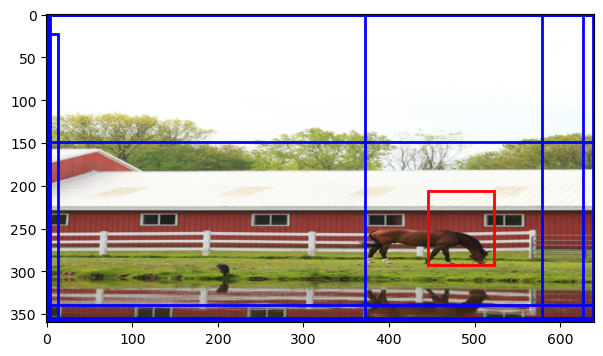

In [245]:
fig, ax = plt.subplots(1, figsize=(12,4))

width   =  640
height  =  360 

ax.imshow(imgs[num].view(height, width, 3)) 

for k in range(65):
    
    rect = patches.Rectangle( (bbox[num][k][1]*width, bbox[num][k][0]*height), bbox[num][k][3]*width, bbox[num][k][2]*height, linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)


for k in range(65): 
    
    rect = patches.Rectangle( ((p_box[0][k][1]*width).cpu(), (p_box[0][k][0]*height).cpu() ), (p_box[0][k][3]*width).cpu(), (p_box[0][k][2]*height).cpu(), linewidth=2, edgecolor='b', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Evaluation Metrices</h2>
</div>

In [217]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [223]:
def calculate_iou(box1, box2):
    # box: [x, y, w, h]
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate area of both boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate intersection
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    inter_w = max(0, inter_x2 - inter_x1)
    inter_h = max(0, inter_y2 - inter_y1)
    intersection = inter_w * inter_h

    # Calculate union
    union = area1 + area2 - intersection

    return intersection / union

# Calculate AP for each image in the batch
def calculate_ap(pred_boxes, scores, gt_boxes, iou_threshold=0.5):
    all_precisions = []
    all_recalls = []

    for i in range(pred_boxes.shape[0]):
        # Sort predictions by score in descending order
        sorted_indices = torch.argsort(scores[i], descending=True)
        sorted_pred_boxes = pred_boxes[i][sorted_indices]

        # Initialize TP, FP, and GT boxes
        tp = np.zeros(len(sorted_pred_boxes))
        fp = np.zeros(len(sorted_pred_boxes))
        gt_detected = np.zeros(len(gt_boxes[i]))

        # Calculate TP and FP
        for j, pred_box in enumerate(sorted_pred_boxes):
            iou_max = 0
            gt_idx = -1
            # Compare with each ground truth box
            for k, gt_box in enumerate(gt_boxes[i]):
                iou = calculate_iou(pred_box, gt_box)
                if iou > iou_max:
                    iou_max = iou
                    gt_idx = k
            # If IoU is greater than the threshold, it's a TP
            if iou_max >= iou_threshold and not gt_detected[gt_idx]:
                tp[j] = 1
                gt_detected[gt_idx] = 1
            else:
                fp[j] = 1

        # Calculate precision and recall
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        precision = tp_cumsum / (tp_cumsum + fp_cumsum)
        recall = tp_cumsum / len(gt_boxes[i])

        # Store precision and recall for this image
        all_precisions.append(precision)
        all_recalls.append(recall)

    # Calculate mean precision over the entire batch
    mean_precisions = np.mean(all_precisions, axis=0)
    mean_recalls = np.mean(all_recalls, axis=0)

    # Calculate AP as the area under the precision-recall curve
    ap = np.trapz(mean_precisions, mean_recalls)

    return ap

In [224]:
ap_score = calculate_ap(pred_boxes, scores, gt_boxes, iou_threshold=0.5)
print(f"Average Precision (AP): {ap_score}")

NameError: name 'pred_boxes' is not defined

In [219]:
average_precision(bbox, p_box)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Sync for WANDB</h2>
</div>

In [ ]:
#run.finish() 